<a href="https://colab.research.google.com/github/opinner/thesis_introductory_figures/blob/main/Introductory_Chapter_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gsw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.6 MB/s eta 0:00:00


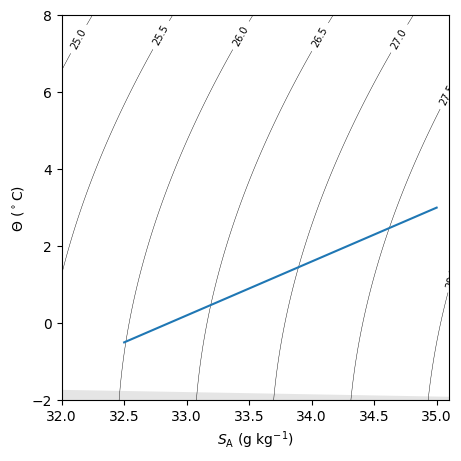

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Nov  8 14:01:07 2024

@author: sreifenb
"""

# First, we import some necessary packages:
import matplotlib.pyplot as plt  # for plotting
import numpy as np               # for numerical operations
import gsw                        # for oceanographic calculations (Gibbs Seawater package)

# Next, we define a function to set up a T-S (temperature-salinity) plot.
# This is a specialized type of plot often used in oceanography to display water mass properties.

def setup_TS_plot(ax=None, figsize=(5,5),
                  sr=[7,45.5], tr=[-3,40], delta_isopyc=2, fmt='%2.1f',
                  xlabel=r"$S_\mathrm{A}$ (g kg$^{-1}$)", ylabel=r"$\Theta$ ($^\circ$C)",
                  nres=100, colors=["k"], fontsize=7, linewidths=.3, add_CT_freeze=True, **kwargs):
    """
    Creates an empty T-S diagram with labels, axis, and potential density lines.
    """

    # Flag to check if a new axis needs to be created
    flag = 0
    if ax is None:  # If no axis is provided, we create one
        fig, ax = plt.subplots(1,1, figsize=figsize)
        flag = 1  # Mark that we created a new axis

    # Define temperature and salinity ranges for the grid (a grid of points to be plotted)
    tmpbins = np.linspace(tr[0]-0.1, tr[1]+0.1, nres, endpoint=True)
    salbins = np.linspace(sr[0]-0.1, sr[1]+0.1, nres, endpoint=True)

    # Create a grid of salinity (Sgr) and temperature (Tgr) values
    Sgr, Tgr = np.meshgrid(salbins, tmpbins)

    # Calculate the potential density anomaly on this grid
    sig_gr = gsw.sigma0(Sgr, Tgr)

    # Plot the potential density lines (called isopycnals) on the plot
    cntr = ax.contour(salbins, tmpbins, sig_gr, colors=colors,
                      linewidths=linewidths, **kwargs,
                      levels=np.arange(0,40,delta_isopyc))  # Adjust level spacing
    plt.clabel(cntr, fmt = fmt, colors = colors, fontsize=fontsize)

    # Set axis labels
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Optionally add a curve showing the freezing temperature of seawater at different salinities
    if add_CT_freeze:
        SA_f = np.linspace(0, 40, 1000)  # Salinity range for the freezing line
        CT_f = gsw.CT_freezing(SA_f, 0, 0)  # Calculate the freezing temperature
        # Fill in the region below the freezing line with a grey shade
        ax.fill_between(SA_f, CT_f, -5, fc="grey", alpha=.2, ec="k", lw=0)

    # Set the plot limits for temperature and salinity
    ax.set_ylim(tr)
    ax.set_xlim(sr)

    # Return the figure and axis if we created a new one
    if flag == 1:
        return fig, ax

#%% HOW TO USE IT

# Define the plot limits for salinity and temperature
salinity_range = [32, 35.1]
temperature_range = [-2, 8]

delta_isopyc=0.5   # This is the step size between the isopycnals (density lines)

# Step 1: Create an empty T-S plot
fig, ax = setup_TS_plot(sr=salinity_range, tr=temperature_range, delta_isopyc=delta_isopyc)

# Step 2: Create some fake data to plot
conservative_temperature = np.linspace(-0.5, 3, 100)  # Example temperature data
absolute_salinity = np.linspace(32.5, 35, 100)        # Example salinity data

# Step 3: Plot the data on the T-S plot
ax.plot(absolute_salinity, conservative_temperature)  # Plotting temperature vs. salinity

In [4]:
! pip install netCDF4 --quiet
# ! pip install basemap --quiet
! pip install cartopy --quiet
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 58.5 MB/s eta 0:00:00


In [5]:
# ! wget https://usicecenter.gov/File/Download?fname=USNIC_ANTARC_shelf_2022.zip
# ! unzip Download?fname=USNIC_ANTARC_shelf_2022.zip

In [6]:
from netCDF4 import Dataset, num2date
import time, calendar, datetime, numpy
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import os
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
#import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import JOIN_STYLE

In [7]:
#if not os.path.exists(filename):
# from https://erddap.ifremer.fr/erddap/tabledap/ArgoFloats.html
#filename, headers = urlretrieve("https://erddap.ifremer.fr/erddap/tabledap/ArgoFloats.nc?time%2Clatitude%2Clongitude&time%3E=1997-07-28T20%3A26%3A20Z&time%3C=2026-12-27T14%3A48%3A20Z&latitude%3E=-99.999&latitude%3C=-56&longitude%3E=-179.9998&orderBy(%22latitude%22)")
#filename, headers = urlretrieve("https://erddap.ifremer.fr/erddap/tabledap/ArgoFloats.nc?time%2Ctime_qc%2Clatitude%2Clongitude&time%3E=2005-07-01&time%3C=2026-12-27T14%3A48%3A20Z&time_qc%3E=%221%22&time_qc%3C=%222%22&latitude%3E=-99.999&latitude%3C=-56&longitude%3E=-179.9998&orderBy(%22latitude%22)")
filename, headers = urlretrieve("https://erddap.ifremer.fr/erddap/tabledap/ArgoFloats.nc?time%2Ctime_qc%2Clatitude%2Clongitude&time%3E=2005-07-01&time%3C=2026-12-27T14%3A48%3A20Z&time_qc%3E=%221%22&time_qc%3C=%222%22&latitude%3E=-99.999&latitude%3C=-40&longitude%3E=-96&longitude%3C=2&orderBy(%22latitude%22)")
dset = Dataset(filename)
lats = dset.variables['latitude'][:]
lons = dset.variables['longitude'][:]
#time = dset.variables['date']  # seconds since epoch
#times = time[:]
# t1 = times.min(); t2 = times.max()
# date1 = num2date(t1, units=time.units)
# date2 = num2date(t2, units=time.units)
dset.close()
#os.remove(filename)

In [9]:
# # cartopy magic to add the 1000m isobath, taken from https://github.com/SciTools/cartopy/issues/1586
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))

delta = 0.0001 #Increase eps depending on your contour resolution
bathym = bathym.buffer(delta, 1, join_style=JOIN_STYLE.bevel).buffer(-delta, 1, join_style=JOIN_STYLE.bevel)

ice_shelves = cfeature.NaturalEarthFeature(
        category='physical',
        name='antarctic_ice_shelves_polys',
        scale='50m',
        facecolor='lightcoral',
        edgecolor='lightcoral')

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_antarctic_ice_shelves_polys.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


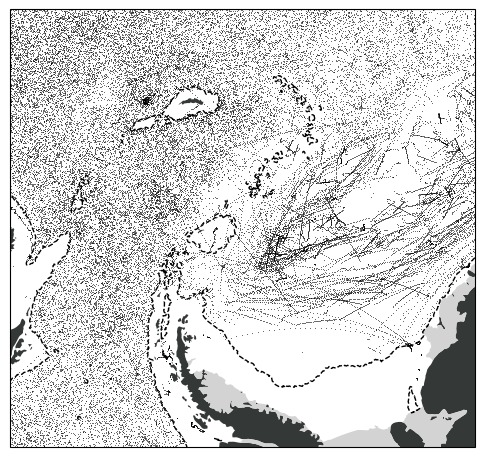

In [10]:
# fig, ax = plt.subplots(1, figsize=(6,6), subplot_kw={"projection":ccrs.LambertAzimuthalEqualArea(central_latitude=-90.0,)})
# ax.set_extent([-90, -10, -70, -65], ccrs.PlateCarree())

fig, ax = plt.subplots(1, figsize=(6,6), subplot_kw={"projection":ccrs.SouthPolarStereo()}) #, dpi=300)
ax.set_extent([-70, -10, -70, -55], ccrs.PlateCarree())

land_50m = cfeature.NaturalEarthFeature('physical', 'land','50m',
                                        edgecolor=None, #'face',
                                        facecolor='xkcd:charcoal')
ax.add_feature(land_50m,)
ax.add_feature(ice_shelves, edgecolor=None, facecolor="lightgrey")
# Does not work with LambertAzimuthalEqualArea
ax.add_geometries(bathym, facecolor='none', edgecolor='black', linestyle="dashed", linewidth=1, crs=ccrs.PlateCarree())

# #ax.gridlines()
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), s=1, edgecolors=None, marker='.', linewidths=0.1, rasterized=True, color="black")
# #plt.box(False)

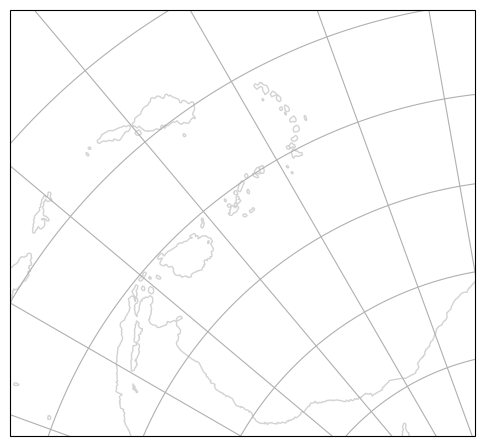

In [11]:
fig, ax = plt.subplots(1, figsize=(6,6), subplot_kw={"projection":ccrs.SouthPolarStereo()}) #, dpi=300)
#fig, ax = plt.subplots(1, figsize=(6,6), subplot_kw={"projection":ccrs.LambertAzimuthalEqualArea(central_latitude=-90.0,)})
ax.set_extent([-60, -10, -70, -55], ccrs.PlateCarree())

# land_50m = cfeature.NaturalEarthFeature('physical', 'land','50m',
#                                         edgecolor=None, #'face',
#                                         facecolor='grey')
# ax.add_feature(land_50m,)
# ax.add_feature(ice_shelves, edgecolor=None)
ax.add_geometries(bathym, facecolor='none', edgecolor='lightgrey', linestyle="solid", linewidth=1, crs=ccrs.PlateCarree())

ax.gridlines()
#ax.scatter(lons, lats, transform=ccrs.PlateCarree(), s=1, edgecolors=None, marker='.', linewidths=0.1, rasterized=True, color="black")
# #plt.box(False)